# Dilation Tensorflow for Semantic Segmentation
- [code with pretrained model](https://github.com/ndrplz/dilation-tensorflow)

In [1]:
!ls -lh ../../models/semantic-segmentation/dilation-tf/dilation_cityscapes/

total 2101192
-rw-r--r--  1 pmal252d  SINGAPOREPOWER\Domain Users    73B Oct 10 16:54 checkpoint
-rw-r--r--  1 pmal252d  SINGAPOREPOWER\Domain Users   513M Oct 10 16:54 dilation.data-00000-of-00001
-rw-r--r--  1 pmal252d  SINGAPOREPOWER\Domain Users   2.1K Oct 10 16:54 dilation.index
-rw-r--r--  1 pmal252d  SINGAPOREPOWER\Domain Users   513M Oct 10 16:54 dilation.meta


In [2]:
import tensorflow as tf
from os import path
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
base_path = "../../models/semantic-segmentation/dilation-tf/dilation_cityscapes/"
output_shape = (1024, 1024, 19)
input_shape = (1396, 1396, 3)
mean_pixel = (72.39, 82.91, 73.16)
conv_margin = 186

palette= np.array([[128, 64, 128],
            [244, 35, 232],
            [70, 70, 70],
            [102, 102, 156],
            [190, 153, 153],
            [153, 153, 153],
            [250, 170, 30],
            [220, 220, 0],
            [107, 142, 35],
            [152, 251, 152],
            [70, 130, 180],
            [220, 20, 60],
            [255, 0, 0],
            [0, 0, 142],
            [0, 0, 70],
            [0, 60, 100],
            [0, 80, 100],
            [0, 0, 230],
            [119, 11, 32]], dtype='uint8')

In [6]:
## load pretrained from model

tf.reset_default_graph()
saver = tf.train.import_meta_graph(path.join(base_path, "dilation.meta"))

sess = tf.Session()
saver.restore(sess, path.join(base_path, "dilation"))

INFO:tensorflow:Restoring parameters from ../../models/semantic-segmentation/dilation-tf/dilation_cityscapes/dilation


In [7]:
graph = tf.get_default_graph()
model_output = graph.get_tensor_by_name('softmax:0')
model_output = tf.reshape(model_output, shape=(1,)+output_shape)
model_input = graph.get_tensor_by_name('input_placeholder:0')

In [8]:
image = imread("../../models/semantic-segmentation/dilation-tf/dilation-tensorflow/data/cityscapes.png")
input_val = imresize(image, input_shape) - mean_pixel
input_val = np.expand_dims(input_val, axis=0)

In [9]:
import cv2

input_dims = (1,) + input_shape
batch_size, input_height, input_width, num_channels = input_dims
# model_in = np.zeros(input_dims, dtype=np.float32)

image_size = image.shape
output_height = input_height - 2 * conv_margin
output_width = input_width - 2 * conv_margin
image = cv2.copyMakeBorder(image, conv_margin, conv_margin,
                           conv_margin, conv_margin,
                           cv2.BORDER_REFLECT_101)

num_tiles_h = image_size[0] // output_height + (1 if image_size[0] % output_height else 0)
num_tiles_w = image_size[1] // output_width  + (1 if image_size[1] % output_width else 0)


row_prediction = []
for h in range(num_tiles_h):
    col_prediction = []
    for w in range(num_tiles_w):
        offset = [output_height * h,
                  output_width * w]
        tile = image[offset[0]:offset[0] + input_height,
                     offset[1]:offset[1] + input_width, :]
        margin = [0, input_height - tile.shape[0],
                  0, input_width - tile.shape[1]]
        tile = cv2.copyMakeBorder(tile, margin[0], margin[1],
                                  margin[2], margin[3],
                                  cv2.BORDER_REFLECT_101)

#         model_in[0] = tile
        prob = sess.run(model_output, feed_dict={model_input: tile[None, ...]})[0]

        col_prediction.append(prob)
    
    col_prediction = np.concatenate(col_prediction, axis=1)  # previously axis=2
    row_prediction.append(col_prediction)

In [10]:
prob = np.concatenate(row_prediction, axis=0)
prediction = np.argmax(prob, axis=2)
color_image = palette[prediction.ravel()].reshape(image_size)

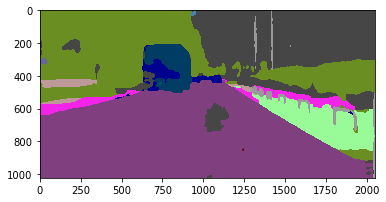

In [11]:
plt.imshow(color_image)

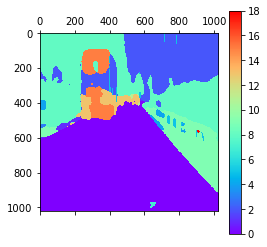

In [49]:

output_val = sess.run(model_output, feed_dict={model_input: input_val})
a = output_val.squeeze().argmax(axis=2)
plt.matshow(a, cmap=plt.cm.rainbow)
plt.colorbar()

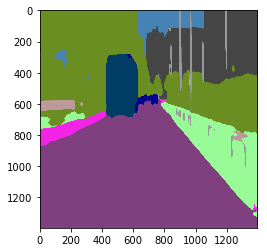

In [50]:
img = imread("../../models/semantic-segmentation/dilation-tf/dilation-tensorflow/data/cityscapes_out.png")

plt.imshow(imresize(img, input_shape))

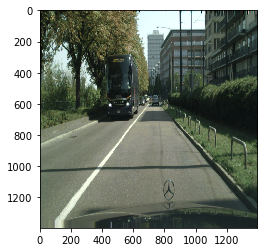

In [44]:
plt.imshow(imresize(img, input_shape))

In [15]:
def segment(image, sess):
    image = image.astype(np.float32) - mean_pixel
    input

In [9]:
sess.close()